In [1]:
# General libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Scikit Learn libraries
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

# Scipy libraries
from scipy import stats
import joblib
import warnings
warnings.filterwarnings('ignore')

# Utils functions
from utils.utils import kfold, five_two, read_datasets, plot_pred_expected_results

# Load Dataset

In [2]:
x_train, x_test, y_train, y_test = read_datasets(
    'x_train.csv',
    'x_test.csv',
    'y_train.csv',
    'y_test.csv'
)

# Gradient Boosting regression - XGBoost

In [3]:
# The cross validation scheme to be used for train and test
folds = kfold()

## GridSearch

In [4]:
hyper_params = {
    'colsample_bytree': [0.1, 0.2, 0.3],
    'n_estimators': [10, 20, 25, 50], #75, 100
    'subsample': [0.5, 0.6, 0.7],
    'max_depth': [1, 2, 3],
    'booster': ['gbtree', 'dart'],
    'objective': ["reg:squarederror"],
    'eta': [0.1, 0.2, 0.3, 0.4, 0.9],
    'gamma': [0, 0.3, 0.5],
    'min_child_weight': [2, 3, 4],
    'max_delta_step':[0, 1],
    'reg_lambda': [0.3, 0.5, 0.7],
    'alpha': [0.2, 0.3, 0.4],
    'tree_method': ['approx', 'auto', 'exact', 'gpu_hist', 'hist'],
    'max_leaves': [0, 1, 3, 5, 8],
    'eval_metric': ['rmse'],
    'base_score': [0.1, 0.3, 0.4, 0.5],
    'grow_policy': ['depthwise'],
    'refresh_leaf': [0,1],
    'sampling_method': ['uniform'],
    'colsample_bylevel': [0.1, 0.2, 0.5, 1],
    'colsample_bynode': [0.1, 0.2, 0.5, 1],
    'colsample_bytree': [0.1, 0.2, 0.4, 1],
    'updater': ['grow_colmaker', 'grow_histmaker', 'grow_quantile_histmaker', 'grow_gpu_hist', 'sync', 'refresh', 'prune']
}




# Call RandomizedSearchCV()
model_cv = RandomizedSearchCV(
    estimator = xgb.XGBRegressor(),
    param_distributions = hyper_params,
    n_iter=15000,
    scoring= 'r2',
    cv = folds,
    verbose = 2,
    return_train_score=True,
    n_jobs = -1,
    refit = True
    )


# Fit the model
best_model = model_cv.fit(x_train, np.ravel(y_train)) 

print(model_cv.best_params_)

Fitting 10 folds for each of 15000 candidates, totalling 150000 fits
[20:56:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/gbm/gbtree.cc:82: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using `tree_method` parameter instead.
{'updater': 'grow_histmaker', 'tree_method': 'approx', 'subsample': 0.7, 'sampling_method': 'uniform', 'reg_lambda': 0.5, 'refresh_leaf': 0, 'objective': 'reg:squarederror', 'n_estimators': 25, 'min_child_weight': 4, 'max_leaves': 3, 'max_depth': 1, 'max_delta_step': 0, 'grow_policy': 'depthwise', 'gamma': 0.5, 'eval_metric': 'rmse', 'eta': 0.3, 'colsample_bytree': 0.1, 'colsample_bynode': 1, 'colsample_bylevel': 1, 'booster': 'dart', 'base_score': 0.3, 'alpha': 0.4}


In [5]:
# Create new model with best_params_ from grid search

xgboost_best = best_model.best_estimator_

In [6]:
# Get the results for each split

def get_best_model_cv_split_results(best_model, n_splits=10, set_type='train'):
    results = []
    best_index = best_model.best_index_
    for i in range(0, n_splits):
        current_split = 'split{}_{}_score'.format(i, set_type)
        split_result = best_model.cv_results_[current_split][best_index]
        results.append(split_result)

    return results

print("Train Results: {}".format(get_best_model_cv_split_results(best_model, 10, 'train')))
print("Validation Results: {}".format(get_best_model_cv_split_results(best_model, 10, 'test')))

Train Results: [0.3066672463456256, 0.3257394732260702, 0.3064217869759662, 0.2974895794525573, 0.3120647200720027, 0.32768759716482243, 0.3140979004185773, 0.30579499734765003, 0.31936593593130247, 0.3062842302516018]
Validation Results: [0.16931765201650306, 0.1269376981470567, 0.2646472208564231, 0.3119195415616982, 0.19341715381609026, -0.04391197858086726, 0.2471486054101285, 0.18056446266062176, 0.20128946916849455, 0.26446489294410136]


In [7]:
#Get the mean and std for the train and test

train_mean = sum(get_best_model_cv_split_results(best_model, 10, 'train'))/10
test_mean = sum(get_best_model_cv_split_results(best_model, 10, 'test'))/10

print("Train mean: {}".format(train_mean))
print("Train std: {}".format(np.std(get_best_model_cv_split_results(best_model, 10, 'train'))))

print("-=-=-=-=-=-=-=-=-=-=-=")

print("Validation mean: {}".format(test_mean))
print("Validation std: {}".format(np.std(get_best_model_cv_split_results(best_model, 10, 'test'))))

Train mean: 0.3121613467186176
Train std: 0.009135398168516598
-=-=-=-=-=-=-=-=-=-=-=
Validation mean: 0.19157947180002505
Validation std: 0.09411174413533142


In [8]:
y_pred = xgboost_best.predict(x_test)
r2 = r2_score(y_test, y_pred)
print("The r2 score on test set: {:.4f}".format(r2))

The r2 score on test set: 0.2681


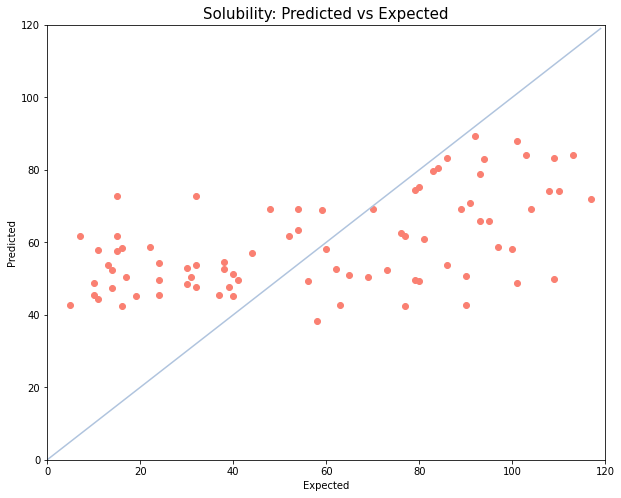

In [9]:
# Plot the R2 predicted and expected results

plot_pred_expected_results(y_test, y_pred)

# Saving trained model

In [10]:
filename = '../models/xgboost_model.joblib'
joblib.dump(xgboost_best, filename)

['../models/xgboost_model.joblib']

## Notes

* Create 10 folds
* Set grid for the RandomSearchCV
* Search and fit the model with best params
* Get the results (r2) for each train and test results for training data
* Get the result (r2) for test data